<h1>Sozin's Comet</h1>


Minor Computational Science

Project Computational Science

<br>
<b>Roku's Bane, consisting of:</b>

Eva Peet (12702803), Nathan Pieterse (12649724) and Koen Weverink (14711982)


In [22]:
"""
The first three imports are self-developed modules, no need to install anything here
"""
from approximations import Approx as app
from asteroids import Asteroids
from comet import Comet

from collections import defaultdict
from decimal import Decimal
from matplotlib.colors import ListedColormap, LinearSegmentedColormap
from numba import jit
from sklearn.metrics import mean_squared_error

import itertools
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import numpy as np
import pandas as pd

In [2]:
dt = 0.001

@jit(forceobj = True)
def sim(V_init: int, M_init: float, angle: int=45) -> tuple[np.ndarray, np.ndarray, np.ndarray, int]:
    """
    Simulates the trajectory of a meteor given:
    The initial velocity, initial mass and angle of entry

    Returns multiple lists containing the mass, velocity, height, width, whether it hit, and the time.
    """

    # Initialize the Comet Class
    comet = Comet(V_init, M_init, angle)

    # Initialize the lists
    masses = np.zeros(900000)
    velocities = np.zeros(900000)
    heights = np.zeros(900000)
    widths = np.zeros(900000)
    t: int = 0

    # Run the sim as long the comet has not burned up or reached earth, with a max simulated time of 15 mins (simulation time)
    while comet.m > 0 and comet.v > 0 and comet.h > 0 and t/dt < 900000:
        
        # Apply the Euler and Velocity Verlet approximations on the comet every timestep
        app.euler(dt, comet)
        app.velocity_verlet(dt, comet)

        # Add the resulting outcomes to their lists
        masses[int(t/dt)] = comet.m
        velocities[int(t/dt)] = comet.v
        heights[int(t/dt)] = comet.h

        # Next timestep
        t += dt

    return masses, velocities, heights, t

<h1><b>Validation of the simulation</b></h1>

Here, the model is tested against an earlier model by Mehta et al. (2018). According to this paper, for each of the initial velocities and masses, the final mass should be 0.02 kg.

In [3]:
# Intial velocities and corresponding minimum masses from Mehta et al. (2018) article to validate simulation
init_velo = [10000, 14000, 18000, 22000, 26000, 30000, 34000, 38000]
init_mass = [0.05, 0.1, 0.2, 0.72, 2.64, 13.5, 132, 13000]

# For each velocity and mass, the error between the estimations from Mehta et al. and the simulation is calculated
Y_pred: list[float] = []

for i in range(len(init_velo)):
    masses, velocities, distances, t = sim(init_velo[i], init_mass[i])
    Y_pred.append(masses[int(t/dt) - 1])


In [4]:
# The final from Mehta et al. (2018) was 0.02; here it is checked the difference between the outcomes using MSE
Y_true = [0.02 for i in range(len(init_velo))]
MSE = mean_squared_error(Y_true, Y_pred)
print("MSE: ", MSE)

MSE:  0.0002964500004550326


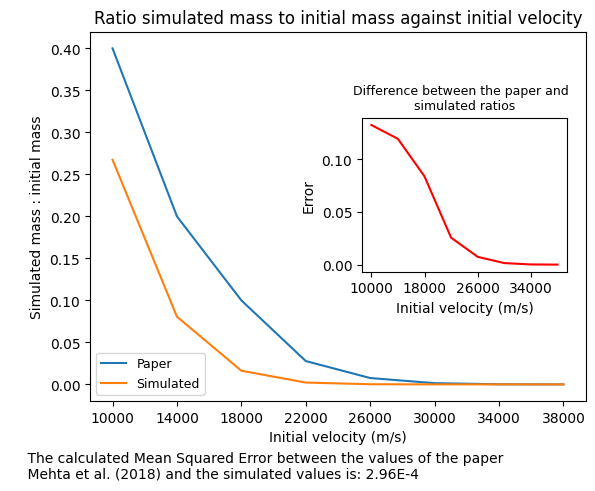

In [5]:
# Normalise the errors by dividing them by their respective initial masses
true_error = [(Y_true[i]) / init_mass[i] for i in range(len(init_mass))]
pred_error = [(Y_pred[i]) / init_mass[i] for i in range(len(init_mass))]

# Get the difference between the predicted and true error
diff = [abs(pred_error[i] - true_error[i]) for i in range(len(init_mass))]

# Initialize the plots
fig, ax1 = plt.subplots()

# Make the first (big) plot, showing the ratio simulated mass to initial mass against initial velocity
ax1.plot(true_error, label='Paper')
ax1.plot(pred_error, label='Simulated')
ax1.set_xticks(ticks=list(range(8)), labels = init_velo)
ax1.set_xlabel('Initial velocity (m/s)')
ax1.set_ylabel('Simulated mass : initial mass')
ax1.set_title('Ratio simulated mass to initial mass against initial velocity')
ax1.legend(loc='lower left', fontsize=9)

# Make the second (small) plot, showing the difference between the paper and simulated ratios
left, bottom, width, height = [0.55, 0.38, 0.32, 0.32]
ax2 = fig.add_axes([left, bottom, width, height])
ax2.plot(diff, c='red')
ax2.set_xticks(ticks=[2*i for i in range(4)], labels=[init_velo[2*i] for i in range(4)])
ax2.set_xlabel('Initial velocity (m/s)')
ax2.set_ylabel('Error')
ax2.set_title('Difference between the paper and  \nsimulated ratios', size=9)

plt.figtext(0.0, -0.05 , f"    The calculated Mean Squared Error between the values of the paper \n\
    Mehta et al. (2018) and the simulated values is: {Decimal(MSE):.2E}")
plt.show()

<h1><b>The experiment</b></h1>

For 30 of the given velocities and masses from the NASA dataset (impacts.csv), the simulation will be run using different angles of impact. 

In [6]:
# Initialize the Asteroids Class and get the initial velocities and masses  
filename = 'nasa_dataset\\impacts.csv'

asteroids = Asteroids(filename)
V_inits = asteroids.velocity()
M_inits = asteroids.mass()

In [45]:
# Run the simulation for 30 asteroids
n = 30
results = defaultdict(dict)

for i in range(n):
    # Generate random angles between 0 and 80 degrees
    angle = np.random.rand() * 80

    # Run the simulation and save the results in a dictionary
    masses, velocities, heights, t = sim(V_inits[i], M_inits[i], angle)
    results[i]['finals'] = (masses[int(t/dt)-1], velocities[int(t/dt)-1], heights[int(t/dt)-1])
    results[i]['angle'] = angle
    results[i]['height'] = heights[heights != 0]
    results[i]['mass'] = masses[masses != 0]
    results[i]['velocity'] = velocities[velocities != 0]
    results[i]['time'] = t


In [56]:
# Create a dataframe 
columns = ['M_init (kg)', 'V_init (m/s)', 'm_fin (kg)', 'h_fin (m)', 'angle', 'time (s)']
df = pd.DataFrame([[M_inits[i], V_inits[i], results[i]['finals'][0], results[i]['finals'][2], results[i]['angle'], results[i]['time']] \
                   for i in range(n)], columns=columns)

In [59]:
# Get the first 5 entries of the dataframe (no funtion, just visualization)
df.head()

,M_init (kg),V_init (m/s),m_fin (kg),h_fin (m),angle,time (s)
0,6.285803e+05,17770.0,1.575649e+04,-0.838722,24.997153,13.024
1,1.466077e+04,8980.0,5.610603e+03,-0.036391,40.262465,40.315
2,1.466077e+04,18330.0,2.133659e+02,-0.006906,42.231394,94.772
3,7.506312e+06,4990.0,5.474395e+06,-0.263266,66.833158,95.617
4,2.249758e+11,19460.0,1.927488e+11,-3.263895,60.820634,21.023


In [61]:
# Get the average time an asteroid needs to hit the Earth's surface from a height of 200 km
print("Average time to hit Earth:", np.mean(df['time (s)']), "seconds")

Average time to hit Earth: 49.82736666671534 seconds


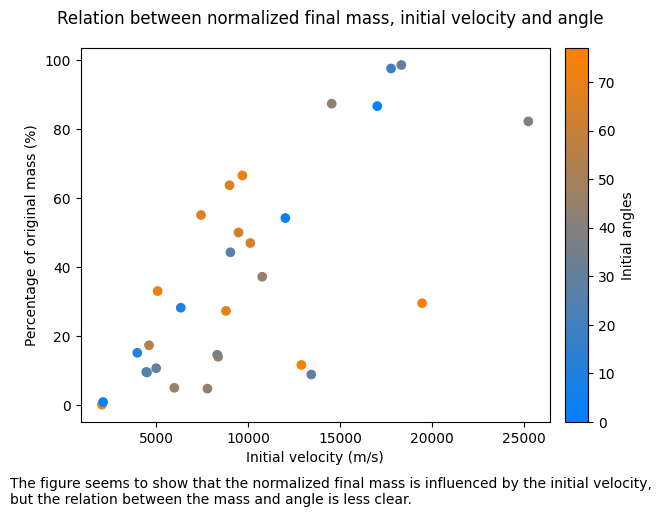

In [23]:
# Plot the relation between the normalized final mass, initial velocity and angle

# Create a colormap for the different angle values
angles = [results[i]['angle'] for i in range(n)]
max_angle = max(angles)
c_ca = [[results[i]['angle'] / max_angle, 0.5, (max_angle - results[i]['angle']) / max_angle] for i in range(n)]

# Initialize the figure with two subplots
fig, (ax1, ax2) = plt.subplots(1, 2, width_ratios=[20, 1])

# Create the scatter plot 
x_var = df['V_init']
y_var = [(df['M_init'][i] - df['m_fin'][i]) / df['M_init'][i] * 100 for i in range(len(df['m_fin']))]
ax1.scatter(x_var, y_var, c=c_ca)

# Create the colorbar 
colors = ["#0080FF", "#FF8000"]
values = [int(min(angles)), int(max(angles))]

norm = mpl.colors.Normalize(vmin=min(values), vmax=max(values))
normed_vals = norm(values)

cmap = LinearSegmentedColormap.from_list("mypalette", list(zip(normed_vals, colors)), N=1000)
cb = mpl.colorbar.ColorbarBase(ax=ax2, cmap=cmap, norm=norm, orientation='vertical')


# Figure layout
ax1.set_xlabel('Initial velocity (m/s)')
ax1.set_ylabel('Percentage of original mass (%)')
ax2.set_ylabel('Initial angles')

plt.suptitle('Relation between normalized final mass, initial velocity and angle')
plt.figtext(0.0, -0.05, s='The figure seems to show that the normalized final mass is influenced by the initial velocity, \n\
but the relation between the mass and angle is less clear.')

fig.tight_layout()

plt.show()

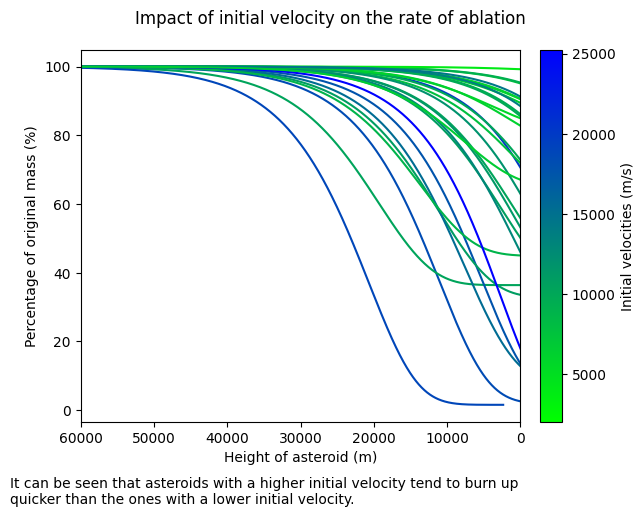

In [11]:
# Plot the impact of initial velocity on the process of ablation

# Create a colormap for the different velocity values
max_Vinit = max([results[i]['velocity'][0] for i in range(n)])
c_c = [[0.0, (max_Vinit - results[i]['velocity'][0]) / max_Vinit, results[i]['velocity'][0] / max_Vinit] for i in range(n)]

# Initialize the figure with two subplots
fig, (ax1, ax2) = plt.subplots(1, 2, width_ratios=[20, 1])

# Create the line plot
for i in range(n):
    norm_mass = [mass / results[i]['mass'][0] * 100 for mass in results[i]['mass']]  
    ax1.plot(results[i]['height'], norm_mass, c=c_c[i])


# Create the colorbar 
colors = ["#00FF00", "#0000FF"]
values = [int(min(V_inits[:n])), int(max(V_inits[:n]))]

norm = mpl.colors.Normalize(vmin=min(values), vmax=max(values))
normed_vals = norm(values)

cmap = LinearSegmentedColormap.from_list("mypalette", list(zip(normed_vals, colors)), N=1000)
cb = mpl.colorbar.ColorbarBase(ax=ax2, cmap=cmap, norm=norm, orientation='vertical')


# Figure layout
ax1.set_xlim(60000, 0)
ax1.set_xlabel('Height of asteroid (m)')
ax1.set_ylabel('Percentage of original mass (%)')
ax2.set_ylabel('Initial velocities (m/s)')
plt.suptitle('Impact of initial velocity on the rate of ablation')
plt.figtext(0.0, -0.05, s='It can be seen that asteroids with a higher initial velocity tend to burn up\n\
quicker than the ones with a lower initial velocity.')
fig.tight_layout()

# Save figure to reproduce for code review 
plt.savefig('reproduced_fig.png', bbox_inches="tight")

plt.show()

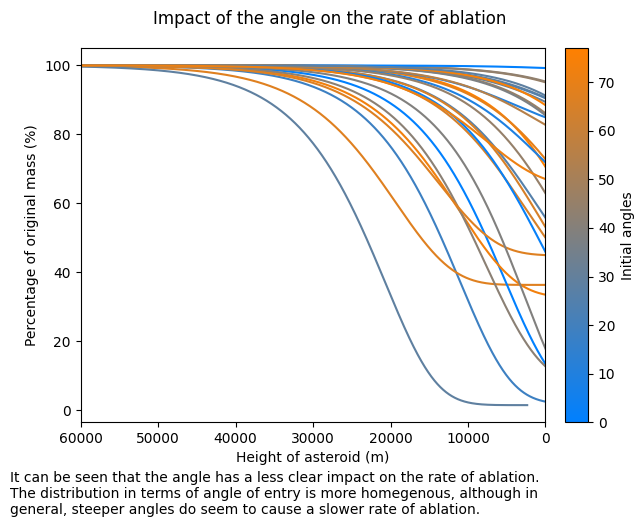

In [12]:
# Plot the impact of the angle on the rate of ablation

# Create a colormap for the different angles
angles = [results[i]['angle'] for i in range(n)]
max_angle = max(angles)
c_ca = [[results[i]['angle'] / max_angle, 0.5, (max_angle - results[i]['angle']) / max_angle] for i in range(n)]


# Initialize the figure with two subplots
fig, (ax1, ax2) = plt.subplots(1, 2, width_ratios=[20, 1])

# Create the line plot
for i in range(n):
    norm_mass = [velo / results[i]['mass'][0] * 100 for velo in results[i]['mass']]  
    ax1.plot(results[i]['height'], norm_mass, c=c_ca[i])


# Create the colorbar 
colors = ["#0080FF", "#FF8000"]
values = [int(min(angles)), int(max(angles))]

norm = mpl.colors.Normalize(vmin=min(values), vmax=max(values))
normed_vals = norm(values)

cmap = LinearSegmentedColormap.from_list("mypalette", list(zip(normed_vals, colors)), N=1000)
cb = mpl.colorbar.ColorbarBase(ax=ax2, cmap=cmap, norm=norm, orientation='vertical')

# Figure layout
ax1.set_xlim(60000, 0)
ax1.set_xlabel('Height of asteroid (m)')
ax1.set_ylabel('Percentage of original mass (%)')
ax2.set_ylabel('Initial angles')
plt.suptitle('Impact of the angle on the rate of ablation')
plt.figtext(0.0, -0.07, s='It can be seen that the angle has a less clear impact on the rate of ablation. \n\
The distribution in terms of angle of entry is more homegenous, although in \n\
general, steeper angles do seem to cause a slower rate of ablation.')
fig.tight_layout()

plt.show()

<h1><b>Sensitivity analysis</b></h1>

Here, sensitivity analysis is performed by modulating the initial velocity and angle, and investigating what the impact of each variable is. The mass is constant and set to 1000 kg.

In [13]:
# Define the variable values
velo_mass_angle = [[5000, 10000],[1000],[20, 45, 70]]

# Create a dictionary to store the results
sens_res = defaultdict(dict)

i = 0
# For each different variable combination
for element in itertools.product(*velo_mass_angle):
    # Run the simulation
    masses, velocities, heights, t  = sim(element[0], element[1], element[2])
    sens_res[i]['angle'] = element[2]
    sens_res[i]['height'] = heights[masses != 0]
    sens_res[i]['mass'] = masses[masses != 0]
    sens_res[i]['velocity'] = velocities[masses != 0]
    i += 1    

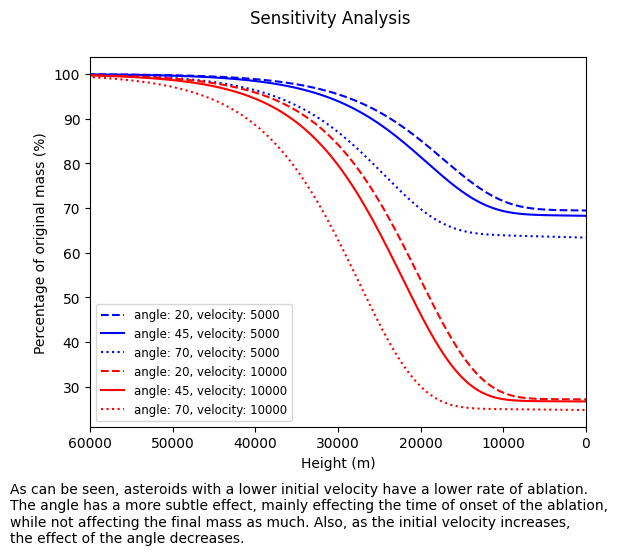

In [14]:
# For every combination the results are plotted with corresponding linestyle and color
for i in range(6):
    norm_mass = [mass / sens_res[i]['mass'][0] * 100 for mass in sens_res[i]['mass']]
    
    if sens_res[i]['velocity'][0] > 9000: 
        color = 'r'
        if sens_res[i]['angle'] == 45: linestyle, label = 'solid', 'angle: 45, velocity: 10000'
        elif sens_res[i]['angle'] == 20: linestyle, label = 'dashed', 'angle: 20, velocity: 10000'
        else: linestyle, label = 'dotted', 'angle: 70, velocity: 10000'
    else: 
        color = 'b'
        if sens_res[i]['angle'] == 45: linestyle, label = 'solid', 'angle: 45, velocity: 5000'
        elif sens_res[i]['angle'] == 20: linestyle, label = 'dashed', 'angle: 20, velocity: 5000'
        else: linestyle, label = 'dotted', 'angle: 70, velocity: 5000'

    plt.plot(sens_res[i]['height'], norm_mass, c = color, linestyle = linestyle, label = label)
    plt.xlim(60000, 0)

# Figure layout
plt.legend(fontsize=8.5)
plt.xlabel('Height (m)')
plt.ylabel('Percentage of original mass (%)')
plt.suptitle('Sensitivity Analysis')
plt.figtext(0.0, -0.13, s='As can be seen, asteroids with a lower initial velocity have a lower rate of ablation. \n\
The angle has a more subtle effect, mainly effecting the time of onset of the ablation, \n\
while not affecting the final mass as much. Also, as the initial velocity increases, \n\
the effect of the angle decreases.')
plt.show()